In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

In [7]:
u_train = np.load('u_train.npy')
output_train = np.load('output_train.npy')
u_test = np.load('u_test.npy')

In [41]:
def create_arx_regressor(y, u, n, m, d):
    N = len(y)
    p = max(n, d + m)
    X = []
    Y = []
    
    for k in range(p, N):
        # Past values of y(k), autoregressive part
        y_lags = [y[k - i] for i in range(1, n+1)]
        
        # Past values of u(k), exogenous input part
        u_lags = [u[k - d - j] for j in range(m + 1)]
        
        # Combine both sets of lags into a single row
        X.append(y_lags + u_lags)
        Y.append(y[k])
    return np.array(X), np.array(Y)

In [42]:
best_score = -np.inf
best_params = {}

# Define ranges for n, m, and d
n_range = range(1, 10)  # Autoregressive order
m_range = range(1, 10)  # Input lag order
d_range = range(1, 10)  # Delay

# Grid search over n, m, and d
for n in n_range:
    for m in m_range:
        for d in d_range:
            
            X_train, Y_train = create_arx_regressor(output_train, u_train, n, m, d)
            
            sample_size = X_train.shape[0]
            test_size = int(0.3*sample_size)
            
            X_train_split = X_train[:-test_size] 
            Y_train_split = Y_train[:-test_size] 
            
            X_val_split = X_train[-test_size:]  
            Y_val_split = Y_train[-test_size:] 
            
            lr = LinearRegression()
            lr.fit(X_train_split, Y_train_split)  # Fit the model with training data
            
            # Split data (or use cross-validation) to compute the R² score or AIC/BIC
            y_val = []
            aux = np.zeros(n)
            y_prev = list(Y_train_split[-n:][::-1])  # Initialize with last n values from the training set
            
            for k in range(test_size):
                # Extract lagged values of u (exogenous inputs) for prediction from X_val_split
                # Assuming that the first n columns in X_val_split are the y lags and the next m+1 columns are u lags
                u_lags = X_val_split[k, n:]  # Extract the lagged u values from the validation set
                
                # Predict using the model
                combined_input = y_prev + list(u_lags)[:m + 1]  # Combine y_prev and m lagged u values

                # Predict using the model
                y_pred = lr.predict([combined_input])  # The model expects a 2D array as input
                y_val.append(y_pred[0])

                # Update the previous values for the next prediction (autoregressive part)
                aux[:] = y_prev[:]  # Copy current values to auxiliary array
                y_prev[0] = y_pred[0]  # Replace the first element with the current prediction
                for i in range(1, n):
                    y_prev[i] = aux[i-1]  # Shift previous values to the right
            score = r2_score(Y_val_split, y_val)
            mse = mean_squared_error(Y_val_split, y_val)

            # Keep track of the best combination of n, m, and d
            if score > best_score:
                best_score = score
                best_mse = mse
                best_params = {'n': n, 'm': m, 'd': d}

print(f"Best n, m, d: {best_params}, with R² score: {best_score} and MSE: {best_mse}")


/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:510: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:510: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  num

Best n, m, d: {'n': 6, 'm': 9, 'd': 6}, with R² score: 0.9995393003054384 and MSE: 0.018363937336676957


/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:510: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


In [81]:
n_final, m_final, d_final = 6,9,6

X_train, Y_train = create_arx_regressor(output_train, u_train, n_final, m_final, d_final)

sample_size = X_train.shape[0]
test_size = int(0.3*sample_size)

X_train_split = X_train[:-test_size] 
Y_train_split = Y_train[:-test_size] 

X_val_split = X_train[-test_size:]  
Y_val_split = Y_train[-test_size:] 

alpha_values = np.linspace(1e-5,0.1,100)
l1_ratios = np.linspace(0.01,1,100)

0.9995393003054384
0.018363937336676957


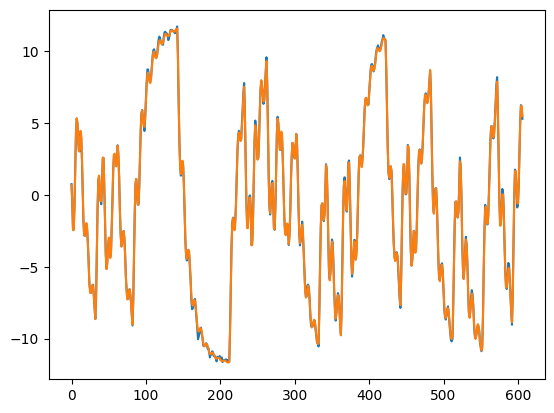

In [82]:
lr = LinearRegression()
lr.fit(X_train_split, Y_train_split)
y_val_OLS = []
aux = np.zeros(n_final)
y_prev = list(Y_train_split[-n_final:][::-1])
for k in range(test_size):
    u_lags = X_val_split[k, n_final:] 
    combined_input = y_prev + list(u_lags)[:m_final + 1]
    y_pred = lr.predict([combined_input])
    y_val_OLS.append(y_pred[0])
    aux[:] = y_prev[:]
    y_prev[0] = y_pred[0]
    for i in range(1, n_final):
        y_prev[i] = aux[i-1]
print(r2_score(Y_val_split, y_val_OLS))
print(mean_squared_error(Y_val_split, y_val_OLS))
plt.plot(Y_val_split, label='True')
plt.plot(y_val_OLS, label='OLS')

      alpha       mse  r2_score
0   0.00001  0.019518   0.99951
1   0.00102  0.019518   0.99951
2   0.00203  0.019518   0.99951
3   0.00304  0.019519   0.99951
4   0.00405  0.019519   0.99951
..      ...       ...       ...
95  0.09596  0.019543   0.99951
96  0.09697  0.019543   0.99951
97  0.09798  0.019543   0.99951
98  0.09899  0.019543   0.99951
99  0.10000  0.019544   0.99951

[100 rows x 3 columns]


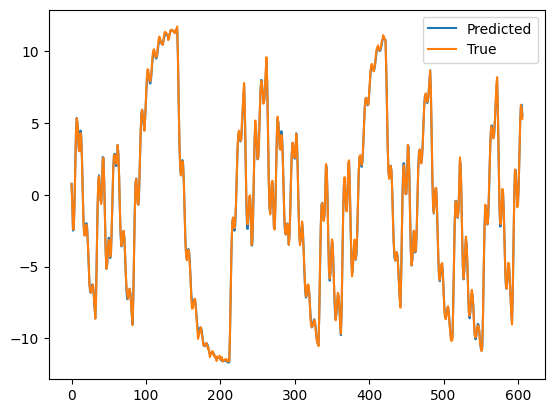

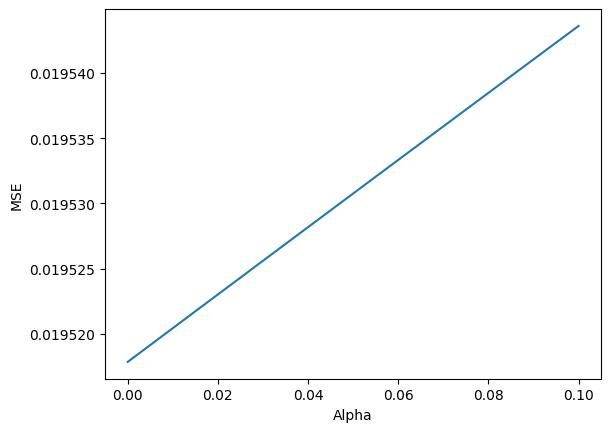

In [80]:
results = [] 

for alpha in alpha_values:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_split, Y_train_split)
        y_val_ridge = []
        aux = np.zeros(n_final)
        y_prev = list(Y_train_split[-n_final:][::-1])  # Initialize with last n values from the training set
        for k in range(test_size):
                u_lags = X_val_split[k, n_final:] 
                combined_input = y_prev + list(u_lags)[:m_final + 1]
                y_pred = ridge.predict([combined_input])
                y_val_ridge.append(y_pred[0])
                aux[:] = y_prev[:]
                y_prev[0] = y_pred[0]
                for i in range(1, n_final):
                        y_prev[i] = aux[i-1]
        score = r2_score(Y_val_split, y_val_ridge)
        mse = mean_squared_error(Y_val_split, y_val_ridge)
        results.append({'alpha': alpha, 'mse': mse, 'r2_score': score})

results_df = pd.DataFrame(results)

print(results_df.sort_values('mse'))
plt.plot(y_val_ridge, label='Predicted')
plt.plot(Y_val_split, label='True')
plt.legend()
plt.show()
plt.plot(results_df['alpha'], results_df['mse'])
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.131e+01, tolerance: 6.268e+00
  model = cd_fast.enet_coordinate_descent(


      alpha       mse  r2_score
0   0.00001  0.018350  0.999540
1   0.00102  0.018526  0.999535
2   0.00203  0.018967  0.999524
3   0.00304  0.019612  0.999508
4   0.00405  0.020753  0.999479
..      ...       ...       ...
95  0.09596  0.190375  0.995224
96  0.09697  0.192662  0.995167
97  0.09798  0.194979  0.995109
98  0.09899  0.197288  0.995051
99  0.10000  0.199587  0.994993

[100 rows x 3 columns]


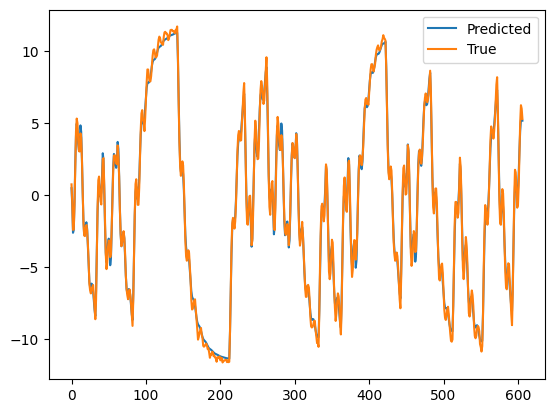

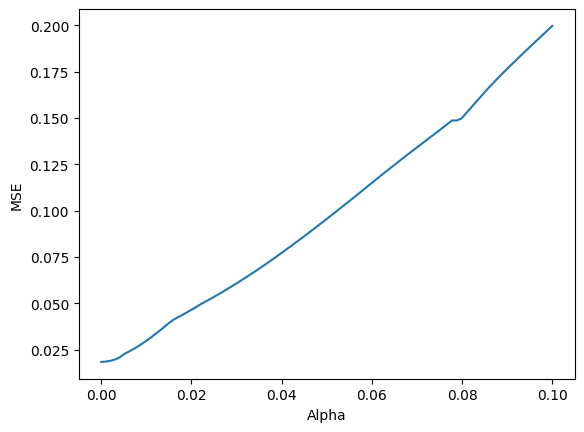

In [59]:
results = [] 

for alpha in alpha_values:
        lasso = Lasso(alpha=alpha,max_iter=10000)
        lasso.fit(X_train_split, Y_train_split)
        y_val_lasso = []
        aux = np.zeros(n_final)
        y_prev = list(Y_train_split[-n_final:][::-1])  # Initialize with last n values from the training set
        for k in range(test_size):
                u_lags = X_val_split[k, n_final:] 
                combined_input = y_prev + list(u_lags)[:m_final + 1]
                y_pred = lasso.predict([combined_input])
                y_val_lasso.append(y_pred[0])
                aux[:] = y_prev[:]
                y_prev[0] = y_pred[0]
                for i in range(1, n):
                        y_prev[i] = aux[i-1]
        score = r2_score(Y_val_split, y_val_lasso)
        mse = mean_squared_error(Y_val_split, y_val_lasso)
        results.append({'alpha': alpha, 'mse': mse, 'r2_score': score})

results_df = pd.DataFrame(results)

print(results_df.sort_values('mse'))
plt.plot(y_val_lasso, label='Predicted')
plt.plot(Y_val_split, label='True')
plt.legend()
plt.show()
plt.plot(results_df['alpha'], results_df['mse'])
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

In [61]:
results = [] 

for l1 in l1_ratios:
        for alpha in alpha_values:
                en = ElasticNet(alpha=alpha,max_iter=100000)
                en.fit(X_train_split, Y_train_split)
                y_val_en = []
                aux = np.zeros(n_final)
                y_prev = list(Y_train_split[-n_final:][::-1])  # Initialize with last n values from the training set
                for k in range(test_size):
                        u_lags = X_val_split[k, n_final:] 
                        combined_input = y_prev + list(u_lags)[:m_final + 1]
                        y_pred = en.predict([combined_input])
                        y_val_en.append(y_pred[0])
                        aux[:] = y_prev[:]
                        y_prev[0] = y_pred[0]
                        for i in range(1, n_final):
                                y_prev[i] = aux[i-1]
                score = r2_score(Y_val_split, y_val_en)
                mse = mean_squared_error(Y_val_split, y_val_en)
                results.append({'l1': l1,'alpha': alpha, 'mse': mse, 'r2_score': score})

results_df = pd.DataFrame(results)

print(results_df)
plt.plot(y_val_en, label='Predicted')
plt.plot(Y_val_split, label='True')
plt.legend()
plt.show()
results_df = results_df.sort_values(by='mse')
print(results_df.head())

/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+01, tolerance: 6.268e+00
  model = cd_fast.enet_coordinate_descent(
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+01, tolerance: 6.268e+00
  model = cd_fast.enet_coordinate_descent(
/home/goncaloribeiro/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

KeyboardInterrupt: 

Best Ridge alpha: 1e-05, with R² score: 0.9994530173782986 and MSE: 0.016932745965112357


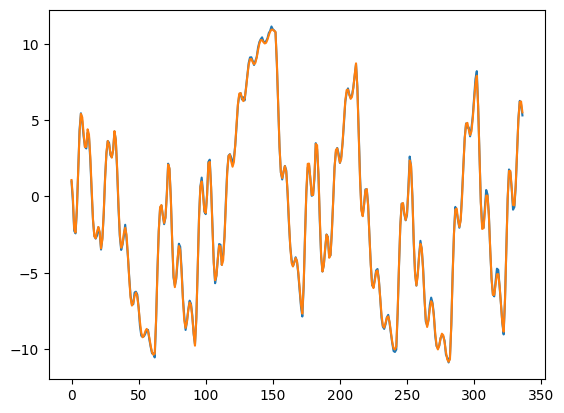

In [85]:
# Initialize TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Define hyperparameters to test for Ridge, Lasso, and ElasticNet
alpha_values = np.linspace(1e-5,0.1,100)  # Tuning regularization strength
l1_ratios = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]    # ElasticNet specific parameter

# Dictionary to store the models
models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet()
}

# To store the best R² score for each model
r2_scores = {model_name: [] for model_name in models.keys()}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # Or however many splits you need

# Initialize an empty dictionary to store R² scores for each model
r2_scores = {
    "OLS": [],
    "Ridge": [],
    "Lasso": [],
    "ElasticNet": []
}


# Loop through each cross-validation fold
for train_index, val_index in tscv.split(X_train):
    X_train_split, X_val_split = X_train[train_index], X_train[val_index]
    Y_train_split, Y_val_split = Y_train[train_index], Y_train[val_index]

    # Train and evaluate each model
    for model_name, model in models.items():
    
        if model_name == "Ridge":
            # Ridge Regression: Test different alpha values
            best_ridge_score = -np.inf
            for alpha in alpha_values:
                ridge = Ridge(alpha=alpha, fit_intercept=True)
                ridge.fit(X_train_split, Y_train_split)

                # Initialize with the last n values from the training set
                y_prev_ridge = list(Y_train_split[-n_final:][::-1])

                y_pred_val_ridge = []
                for k in range(len(Y_val_split)):
                    # Extract lagged u values from the validation set
                    u_lags = X_val_split[k, n_final:]  # Assume first n columns are y lags, remaining are u lags
                    
                    # Combine previous y lags and exogenous u lags for prediction
                    combined_input_ridge = y_prev_ridge + list(u_lags)[:m_final + 1]

                    # Predict using the model
                    y_pred = ridge.predict([combined_input_ridge])
                    y_pred_val_ridge.append(y_pred[0])

                    # Update autoregressive y lags for the next prediction
                    y_prev_ridge = [y_pred[0]] + y_prev_ridge[:-1]  # Update y_prev by shifting new prediction
                    
                # Compute R² score for this fold
                r2 = r2_score(Y_val_split, y_pred_val_ridge)
                mse = mean_squared_error(Y_val_split, y_pred_val_ridge)
                
                if r2 > best_ridge_score:
                    best_ridge_score = r2
                    best_alpha_ridge = alpha
                    best_mse_ridge = mse

            # Store the best R² score for Ridge
            r2_scores["Ridge"].append(best_ridge_score)
            
print(f"Best Ridge alpha: {best_alpha_ridge}, with R² score: {best_ridge_score} and MSE: {best_mse_ridge}")
plt.plot(Y_val_split, label='True')
plt.plot(y_pred_val_ridge, label='Predicted')

In [ ]:
# For Lasso
        elif model_name == "Lasso":
            best_lasso_score = -np.inf
            for alpha in alpha_values:
                y_prev_lasso = list(Y_train_split[-n:][::-1])
                lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter = 10000)
                lasso.fit(X_train_split, Y_train_split)
                y_pred_val_lasso = []
                for k in range(len(Y_val_split)):
                    # Extract lagged u values from the validation set
                    u_lags = X_val_split[k, n:]  # Assume first n columns are y lags, remaining are u lags
                    
                    # Predict using the model
                    combined_input = y_prev_lasso + list(u_lags)[:m+1]  # Combine y_prev and u_lags
                    y_pred = lasso.predict([combined_input])  # Ensure input is 2D
                    
                    y_pred_val_lasso.append(y_pred[0])
                    
                    # Update autoregressive y lags for the next prediction
                    y_prev_lasso = [y_pred[0]] + y_prev_lasso[:-1]  # Shift autoregressive lags
                r2 = r2_score(Y_val_split, y_pred_val_lasso)
                if r2 > best_lasso_score:
                    best_lasso_score = r2
                    best_alpha_lasso = alpha
            r2_scores["Lasso"].append(best_lasso_score)

        # For ElasticNet
        elif model_name == "ElasticNet":
            best_elasticnet_score = -np.inf
            for alpha in alpha_values:
                for l1_ratio in l1_ratios:
                    y_prev_enet = list(Y_train_split[-n:][::-1])
                    enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True)
                    enet.fit(X_train_split, Y_train_split)
                    y_pred_val_enet = []
                    for k in range(len(Y_val_split)):
                        # Extract lagged u values from the validation set
                        u_lags = X_val_split[k, n:]  # Assume first n columns are y lags, remaining are u lags
                        
                        # Predict using the model
                        combined_input = y_prev_enet + list(u_lags)[:m+1]  # Combine y_prev and u_lags
                        y_pred = enet.predict([combined_input])  # Ensure input is 2D
                        
                        y_pred_val_enet.append(y_pred[0])
                        
                        # Update autoregressive y lags for the next prediction
                        y_prev_enet = [y_pred[0]] + y_prev_enet[:-1]  # Shift autoregressive lags
                    r2 = r2_score(Y_val_split, y_pred_val_enet)
                    if r2 > best_elasticnet_score:
                        best_elasticnet_score = r2
                        best_alpha_elastic_net = alpha
                        best_ratio_en = l1_ratio
            r2_scores["ElasticNet"].append(best_elasticnet_score)

        # For OLS (Ordinary Least Squares)
        elif model_name == "OLS":
            
            lr = LinearRegression()
            lr.fit(X_train_split, Y_train_split)  # Fit the model with training data
            y_prev_OLS = list(Y_train_split[-n:][::-1])
            y_pred_val_OLS = []
            aux = np.zeros(n)  # Temp array to hold lagged y values
            y_prev_OLS = list(Y_train_split[-n:][::-1])  # Initialize y_prev with last n values from training set
            
            
            for k in range(len(Y_val_split)):
                # Extract lagged u values from the validation set
                u_lags = X_val_split[k, n:]  # Assume first n columns are y lags, remaining are u lags

                # Predict using the model
                combined_input = y_prev_OLS + list(u_lags)[:m+1]  # Combine y_prev and u_lags
                y_pred = lr.predict([combined_input])  # Ensure input is 2D
                
                y_pred_val_OLS.append(y_pred[0])

                # Update autoregressive y lags for the next prediction
                y_prev_OLS = [y_pred[0]] + y_prev_OLS[:-1]  # Shift autoregressive lags

            # Compute R² score and store it
            # Initialize the "OLS" key in the r2_scores dictionary if it doesn't exist
            if "OLS" not in r2_scores:
                r2_scores["OLS"] = []

            r2 = r2_score(Y_val_split, y_pred_val_OLS)
            r2_scores["OLS"].append(r2)
# Compute the average R² score for each model across all folds
mean_r2_scores = {model_name: np.mean(scores) for model_name, scores in r2_scores.items()}
print(f"Best Ridge alpha: {best_alpha_ridge}, Best Lasso alpha: {best_alpha_lasso}, Best ElasticNet alpha: {best_alpha_elastic_net}, Best ElasticNet l1_ratio: {best_ratio_en}")

# Print the average R² scores for all models
for model_name, mean_r2 in mean_r2_scores.items():
    print(f"Mean R² score for {model_name}: {mean_r2}")

/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.372e+00, tolerance: 1.190e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.325e+00, tolerance: 1.190e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.267e+00, toleranc

Best Ridge alpha: 0.001, Best Lasso alpha: 0.001, Best ElasticNet alpha: 0.001, Best ElasticNet l1_ratio: 0.01
Mean R² score for OLS: 0.9994891879894701
Mean R² score for Ridge: 0.9995046072191105
Mean R² score for Lasso: 0.999487302380035
Mean R² score for ElasticNet: 0.9994976943960502


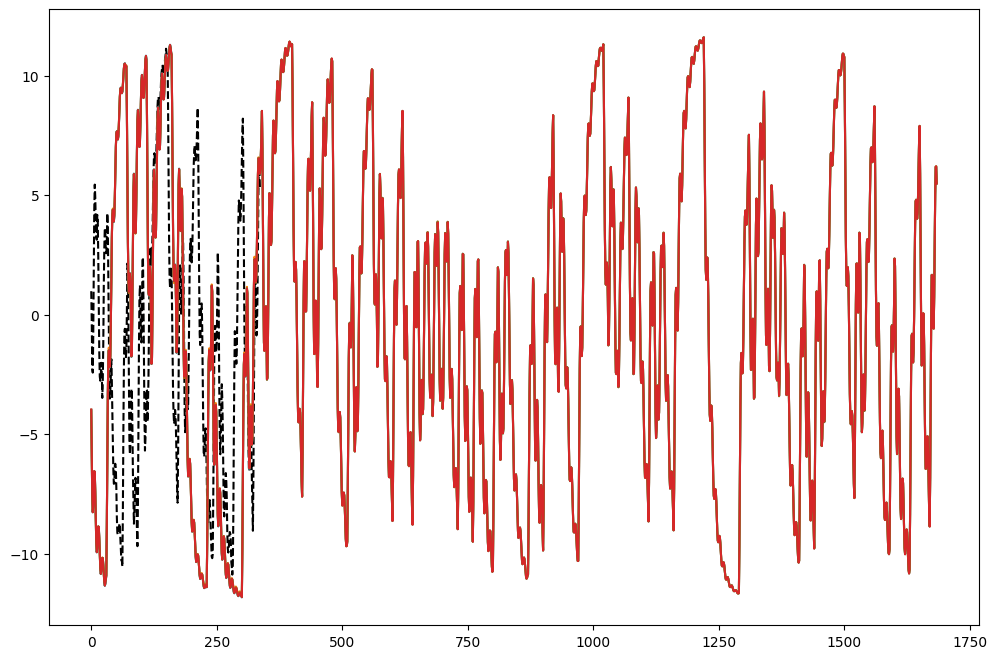

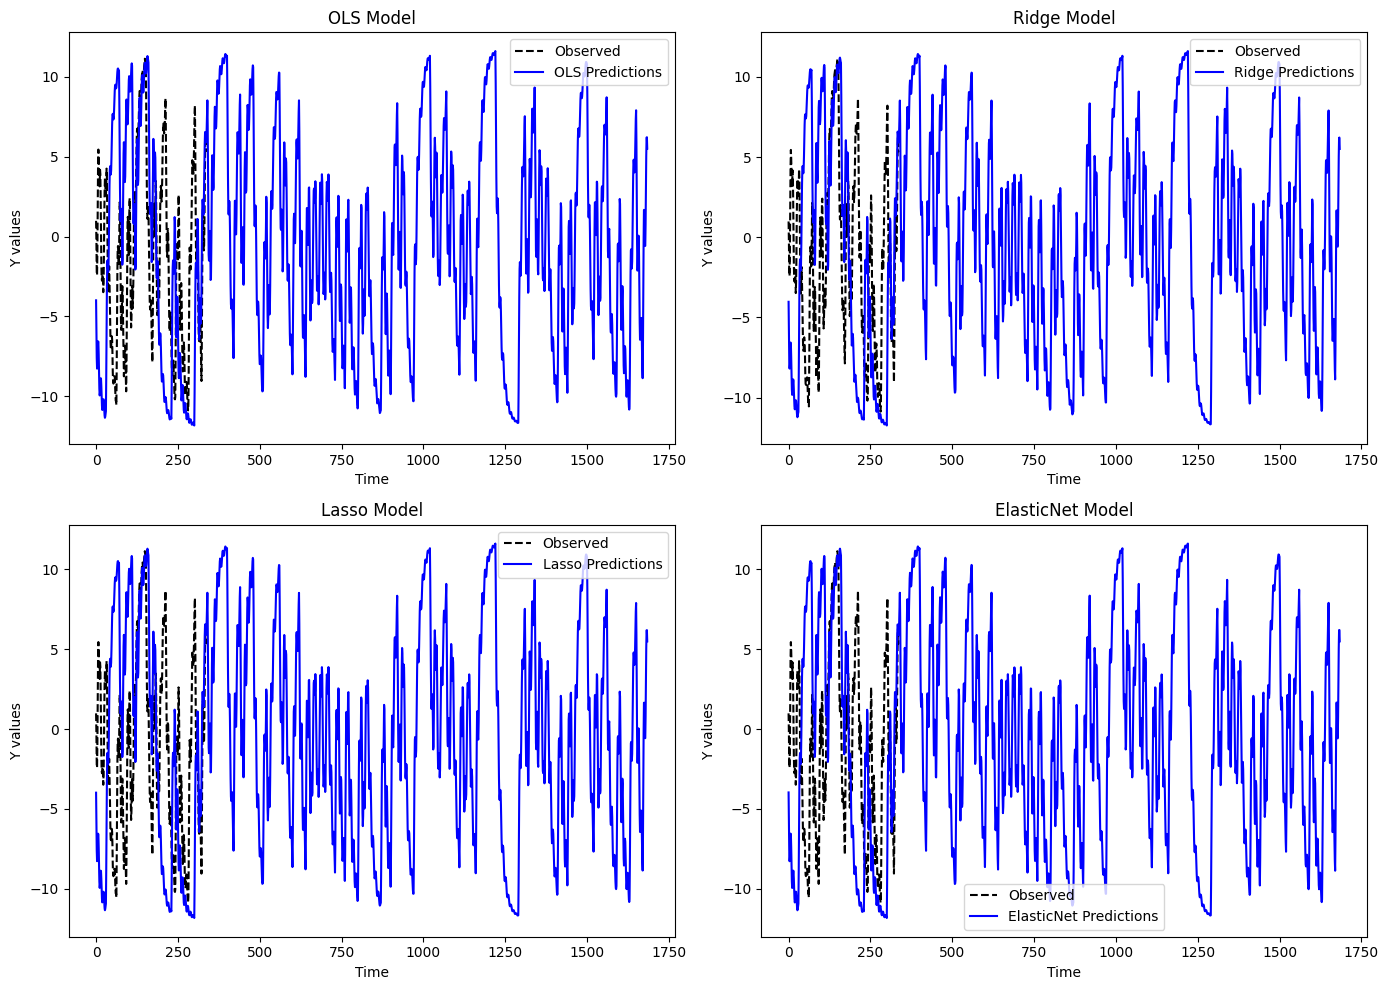

/var/folders/5r/f4n19swn3hj257pxz90vr3v00000gn/T/ipykernel_1108/4076868640.py:174: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


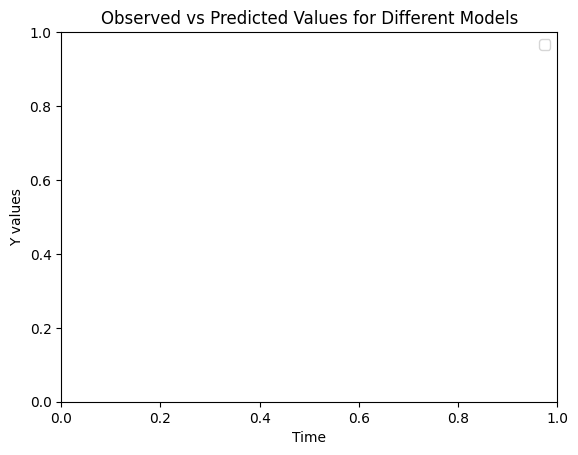

In [30]:
import matplotlib.pyplot as plt

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Dictionary to store the best predictions for each model
best_predictions = {
    "OLS": [],
    "Ridge": [],
    "Lasso": [],
    "ElasticNet": []
}

# Initialize a dictionary to store R² scores for each model
r2_scores = {
    "OLS": [],
    "Ridge": [],
    "Lasso": [],
    "ElasticNet": []
}

# Loop through each cross-validation fold
for train_index, val_index in tscv.split(X_train):
    X_train_split, X_val_split = X_train[train_index], X_train[val_index]
    Y_train_split, Y_val_split = Y_train[train_index], Y_train[val_index]

    # Train and evaluate each model
    for model_name, model in models.items():
    
        if model_name == "Ridge":
            best_ridge_score = -np.inf
            for alpha in alpha_values:
                ridge = Ridge(alpha=alpha, fit_intercept=True)
                ridge.fit(X_train_split, Y_train_split)

                y_prev_ridge = list(Y_train_split[-n:][::-1])
                y_pred_val_ridge = []
                for k in range(len(Y_val_split)):
                    u_lags = X_val_split[k, n:]  # Assume first n columns are y lags, remaining are u lags
                    combined_input_ridge = y_prev_ridge + list(u_lags)[:m + 1]
                    y_pred = ridge.predict([combined_input_ridge])
                    y_pred_val_ridge.append(y_pred[0])
                    y_prev_ridge = [y_pred[0]] + y_prev_ridge[:-1]  # Update autoregressive y lags
                    
                r2 = r2_score(Y_val_split, y_pred_val_ridge)
               
                if r2 > best_ridge_score:
                    best_ridge_score = r2
                    best_alpha_ridge = alpha
                    best_ridge_predictions = y_pred_val_ridge

            r2_scores["Ridge"].append(best_ridge_score)
            best_predictions["Ridge"].extend(best_ridge_predictions)

        # Similar logic for Lasso
        elif model_name == "Lasso":
            best_lasso_score = -np.inf
            for alpha in alpha_values:
                lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000)
                lasso.fit(X_train_split, Y_train_split)

                y_prev_lasso = list(Y_train_split[-n:][::-1])
                y_pred_val_lasso = []
                for k in range(len(Y_val_split)):
                    u_lags = X_val_split[k, n:]
                    combined_input_lasso = y_prev_lasso + list(u_lags)[:m + 1]
                    y_pred = lasso.predict([combined_input_lasso])
                    y_pred_val_lasso.append(y_pred[0])
                    y_prev_lasso = [y_pred[0]] + y_prev_lasso[:-1]
                    
                r2 = r2_score(Y_val_split, y_pred_val_lasso)
                
                if r2 > best_lasso_score:
                    best_lasso_score = r2
                    best_alpha_lasso = alpha
                    best_lasso_predictions = y_pred_val_lasso
            
            r2_scores["Lasso"].append(best_lasso_score)
            best_predictions["Lasso"].extend(best_lasso_predictions)

        # Similar logic for ElasticNet
        elif model_name == "ElasticNet":
            best_elasticnet_score = -np.inf
            for alpha in alpha_values:
                for l1_ratio in l1_ratios:
                    enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True)
                    enet.fit(X_train_split, Y_train_split)

                    y_prev_enet = list(Y_train_split[-n:][::-1])
                    y_pred_val_enet = []
                    for k in range(len(Y_val_split)):
                        u_lags = X_val_split[k, n:]
                        combined_input_enet = y_prev_enet + list(u_lags)[:m + 1]
                        y_pred = enet.predict([combined_input_enet])
                        y_pred_val_enet.append(y_pred[0])
                        y_prev_enet = [y_pred[0]] + y_prev_enet[:-1]
                    
                    r2 = r2_score(Y_val_split, y_pred_val_enet)
                    
                    if r2 > best_elasticnet_score:
                        best_elasticnet_score = r2
                        best_alpha_elastic_net = alpha
                        best_ratio_en = l1_ratio
                        best_enet_predictions = y_pred_val_enet
            
            r2_scores["ElasticNet"].append(best_elasticnet_score)
            best_predictions["ElasticNet"].extend(best_enet_predictions)

        # OLS model
        elif model_name == "OLS":
            lr = LinearRegression()
            lr.fit(X_train_split, Y_train_split)

            y_prev_OLS = list(Y_train_split[-n:][::-1])
            y_pred_val_OLS = []
            for k in range(len(Y_val_split)):
                u_lags = X_val_split[k, n:]
                combined_input_OLS = y_prev_OLS + list(u_lags)[:m + 1]
                y_pred = lr.predict([combined_input_OLS])
                y_pred_val_OLS.append(y_pred[0])
                y_prev_OLS = [y_pred[0]] + y_prev_OLS[:-1]
                
            r2 = r2_score(Y_val_split, y_pred_val_OLS)
            r2_scores["OLS"].append(r2)
            best_predictions["OLS"].extend(y_pred_val_OLS)

# Compute the average R² score for each model across all folds
mean_r2_scores = {model_name: np.mean(scores) for model_name, scores in r2_scores.items()}

# Print the average R² scores for all models
print(f"Best Ridge alpha: {best_alpha_ridge}, Best Lasso alpha: {best_alpha_lasso}, Best ElasticNet alpha: {best_alpha_elastic_net}, Best ElasticNet l1_ratio: {best_ratio_en}")
for model_name, mean_r2 in mean_r2_scores.items():
    print(f"Mean R² score for {model_name}: {mean_r2}")

# Plot the observed vs predicted values for each model
plt.figure(figsize=(12, 8))
plt.plot(Y_val_split, label='Observed', color='black', linestyle='--')

# Plot the predictions for each model
for model_name, predictions in best_predictions.items():
    plt.plot(range(len(predictions)), predictions, label=f'{model_name} Predictions')


# Plot the observed vs predicted values for each model in separate subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Flatten axes for easy indexing
axes = axes.flatten()

# List of models for looping
model_names = ["OLS", "Ridge", "Lasso", "ElasticNet"]

# Plot each model's predictions on a separate subplot
for i, model_name in enumerate(model_names):
    axes[i].plot(Y_val_split, label='Observed', color='black', linestyle='--')
    axes[i].plot(range(len(best_predictions[model_name])), best_predictions[model_name], label=f'{model_name} Predictions', color='blue')
    
    # Labels and title for each subplot
    axes[i].set_title(f'{model_name} Model')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Y values')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()


plt.xlabel('Time')
plt.ylabel('Y values')
plt.title('Observed vs Predicted Values for Different Models')
plt.legend()
plt.show()


In [ ]:
best_model = LinearRegression()
best_model.fit(X_train, Y_train)
for 

/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e+01, tolerance: 7.667e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e+01, tolerance: 7.667e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.245e+01, toleranc

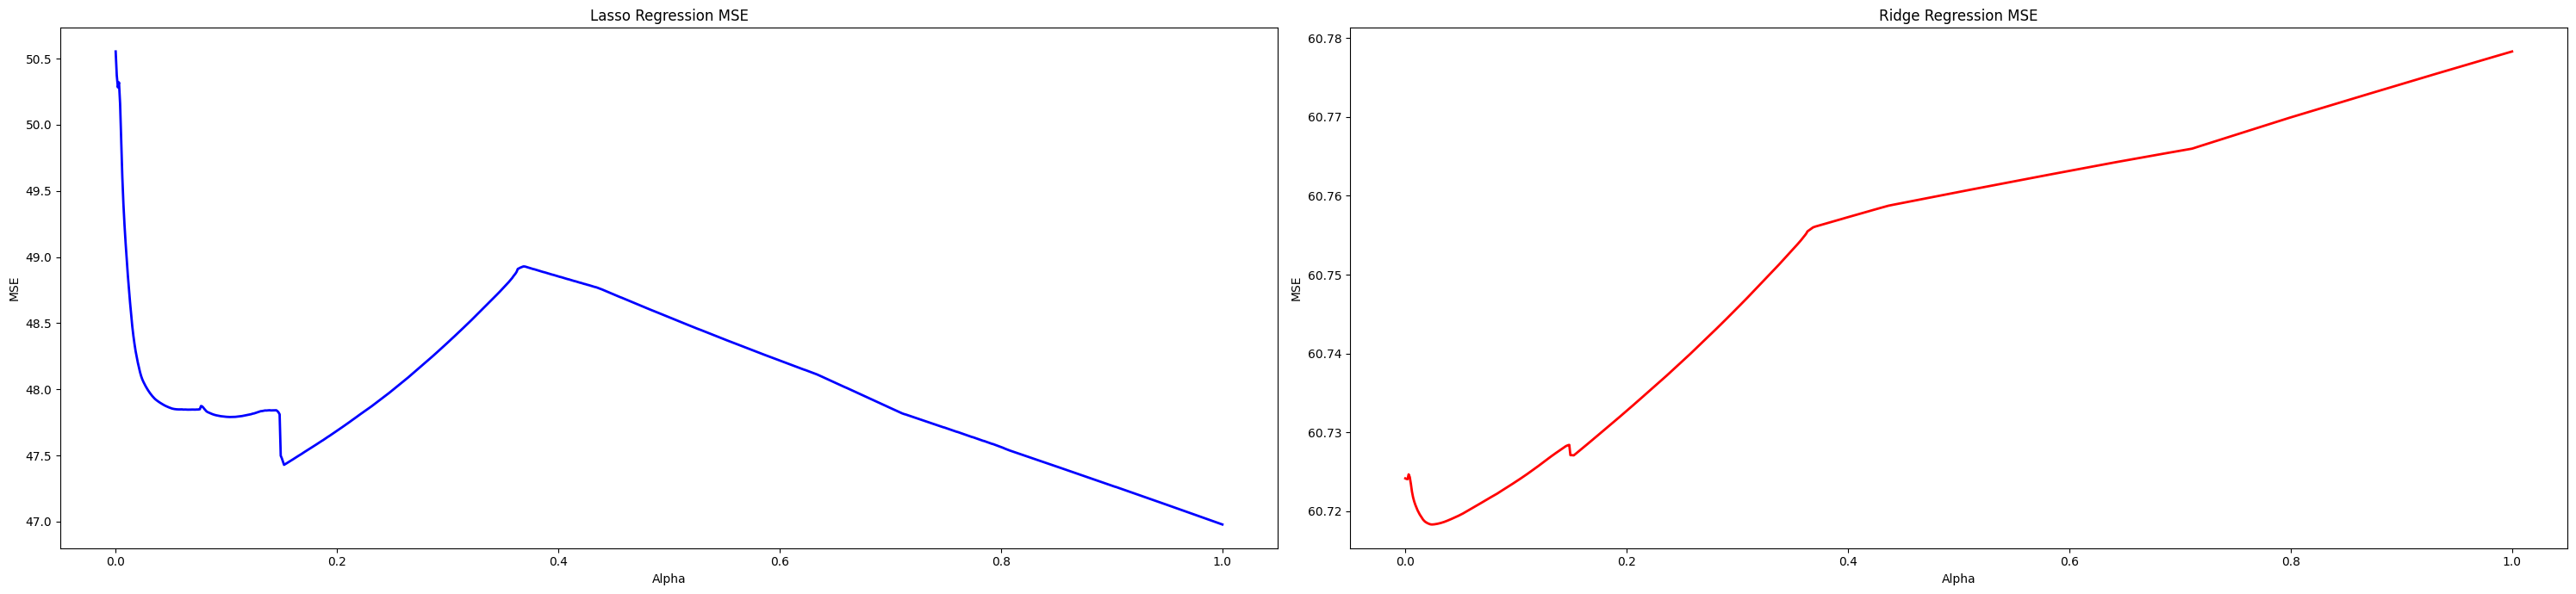

In [85]:
# alpha = np.linspace(0.0001, 1, 1000)
# ratios = np.linspace(0.0001, 1, 100)
# lasso_mse_array = []
# ridge_mse_array = []
# lasso_r2_array = []
# ridge_r2_array = []

# for i in range(0,len(alpha)):
#     y_pred_val_lasso = []
#     y_pred_val_ridge = []
#     lasso = Lasso(alpha=alpha[i], fit_intercept=True)
#     lasso.fit(X_train_split, Y_train_split)
#     for k in range(len(Y_val_split)):
#         # Extract lagged u values from the validation set
#         u_lags = X_val_split[k, n:]  # Assume first n columns are y lags, remaining are u lags
                        
#         # Predict using the model
#         y_pred = ridge.predict([y_prev + list(u_lags)])
#         y_pred_val_ridge.append(y_pred[0])
                        
#         # Update the autoregressive y lags for the next prediction
#         aux[:] = y_prev[:]
#         y_prev[0] = y_pred[0]
#         for i in range(1, n):
#             y_prev[i] = aux[i-1]
#     lasso_mse = mean_squared_error(Y_val_split, y_pred_val_lasso)
#     lasso_mse_array.append([alpha[i], lasso_mse])
#     lasso_r2_array.append([alpha[i], r2_score(y_pred_val_lasso, Y_val_split)])
    
#     ridge = Ridge(alpha=alpha[i],fit_intercept=True)
#     ridge.fit(X_train_split, Y_train_split)
#     for k in range(len(Y_val_split)):
#         # Extract lagged u values from the validation set
#         u_lags = X_val_split[k, n:]  # Assume first n columns are y lags, remaining are u lags
                        
#         # Predict using the model
#         y_pred = ridge.predict([y_prev + list(u_lags)])
#         y_pred_val_ridge.append(y_pred[0])
                        
#         # Update the autoregressive y lags for the next prediction
#         aux[:] = y_prev[:]
#         y_prev[0] = y_pred[0]
#         for i in range(1, n):
#             y_prev[i] = aux[i-1]
#     ridge_mse = mean_squared_error(Y_val_split, y_pred_val_ridge)
#     ridge_mse_array.append([alpha[i], ridge_mse])
#     ridge_r2_array.append([alpha[i], r2_score(y_pred_val_ridge, Y_val_split)])

# lasso_mse_array = np.array(lasso_mse_array)
# ridge_mse_array = np.array(ridge_mse_array)

# fig, axes = plt.subplots(1, 2, figsize=(30, 7))
# axes[0].plot(lasso_mse_array[:,0], lasso_mse_array[:,1], color='blue', linewidth=2, label='Lasso')
# axes[0].set_title('Lasso Regression MSE')
# axes[0].set_xlabel('Alpha')                
# axes[0].set_ylabel('MSE')                  
# axes[1].plot(ridge_mse_array[:,0], ridge_mse_array[:,1], color='red', linewidth=2, label='Ridge')
# axes[1].set_title('Ridge Regression MSE') 
# axes[1].set_xlabel('Alpha')               
# axes[1].set_ylabel('MSE')                  
# plt.tight_layout() 
# plt.show()

In [86]:
print(lasso_r2_array)
print(ridge_r2_array)

[[0.0001, -1.5124020131163003], [0.001100900900900901, -1.5275254007149668], [0.0021018018018018015, -1.5348172787771035], [0.0031027027027027026, -1.5287782237992502], [0.004103603603603604, -1.5432285524907923], [0.005104504504504504, -1.5700757937753718], [0.006105405405405406, -1.5990136247136273], [0.0071063063063063064, -1.6211160339206523], [0.008107207207207206, -1.6387072446872852], [0.009108108108108108, -1.653853370182238], [0.010109009009009007, -1.6678099149121604], [0.011109909909909909, -1.6810519194820461], [0.01211081081081081, -1.6930455290402477], [0.01311171171171171, -1.7046379299315464], [0.014112612612612612, -1.7152169937701265], [0.015113513513513512, -1.7257529170066648], [0.016114414414414413, -1.7346169788856702], [0.017115315315315315, -1.7422279990617238], [0.018116216216216216, -1.7489986192533036], [0.019117117117117114, -1.7545954471408987], [0.020118018018018016, -1.75980271008188], [0.021118918918918917, -1.7645193063425695], [0.02211981981981982, -1.

In [87]:

# for i in alpha:
#     for j in ratios:
#         y_pred_val_en = []
#         en_mse_array = []
#         en_r2_array = []
#         en = ElasticNet(alpha=i, l1_ratio=j)
#         en.fit(X_train_split, Y_train_split)
#         for k in range(test_size):
#             u_lags = [u_train[index + p + k - d - j] for j in range(m + 1)]
#             y_pred = en.predict([y_prev + u_lags])
#             y_pred_val_en.append(y_pred[0])
#             aux1 = y_prev[0]
#             aux2 = y_prev[1] if len(y_prev) > 1 else None
#             aux3 = y_prev[2] if len(y_prev) > 2 else None
#             # y_prev[0] = y_pred[0]
#             if aux2 is not None:
#                 y_prev[1] = aux1
#             if aux3 is not None:
#                 y_prev[2] = aux2
#         en_mse = mean_squared_error(Y_val_split, y_pred_val_en)
#         en_mse_array.append([i, j, en_mse])
#         en_r2_array.append([i,j, r2_score(y_pred_val_en, Y_val_split)])

# en_mse_array = np.array(en_mse_array)
# L1_ratio_results = pd.DataFrame(en_mse_array, columns=['Alpha', 'L1_Ratio', 'MSE']).sort_values(by='MSE')
# print(L1_ratio_results.head())